In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('./data/train_data.csv')


## Encodage des Variables

In [36]:
continuous_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
categorical_features = ["Geography", "Gender", "Tenure",
                 "NumOfProducts", "HasCrCard", "IsActiveMember", "Exited"]

encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded_data = encoder.fit_transform(df[["Gender", "Geography"]])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["Gender", "Geography"]))

df = df.drop(columns=["Gender", "Geography"]).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

df.head()  



,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,0,1.0,0.0,0.0
1,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,0,1.0,0.0,0.0
2,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,0,1.0,0.0,0.0
3,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,1,0.0,1.0,0.0
4,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,0,0.0,0.0,0.0


## Feature Engineering

In [37]:
df["BalanceMinusSalary"] = df["Balance"] - df["EstimatedSalary"]
df["CreditScorePerBalance"] = df["CreditScore"] / (df["Balance"] +1)
df["CreditScorePerBalancePerTenure"] = df["CreditScorePerBalance"] / (df["Tenure"] +1)
df["BalancePerTenure"] = df["Balance"] / (df["Tenure"] +1)



## Feature Selection

In [38]:
df.drop(columns=["CustomerId", "Surname", "ID", "Tenure", "CreditScore", "EstimatedSalary", "HasCrCard"], inplace=True)

## Normalisation

In [39]:
numeric_cols = ["Age", "Balance", "CreditScorePerBalance", "CreditScorePerBalancePerTenure", "BalancePerTenure", "BalanceMinusSalary"]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print(df.head())

        Age   Balance  NumOfProducts  IsActiveMember  Exited  Gender_Male  \
0 -1.143467  1.212313              1             1.0       0          1.0   
1 -0.467158 -0.883978              2             1.0       0          1.0   
2  0.096433 -0.883978              2             1.0       0          1.0   
3  2.012643  1.003521              3             0.0       1          0.0   
4 -0.579876 -0.883978              2             1.0       0          0.0   

   Geography_Germany  Geography_Spain  BalanceMinusSalary  \
0                0.0              0.0            0.342932   
1                0.0              0.0           -1.552439   
2                0.0              0.0           -0.547323   
3                1.0              0.0            1.427498   
4                0.0              0.0           -0.583198   

   CreditScorePerBalance  CreditScorePerBalancePerTenure  BalancePerTenure  
0              -1.072491                       -0.714336          0.150637  
1               

In [40]:
# Define Features & Target
X = df.drop(columns=["Exited"])
y = df["Exited"]

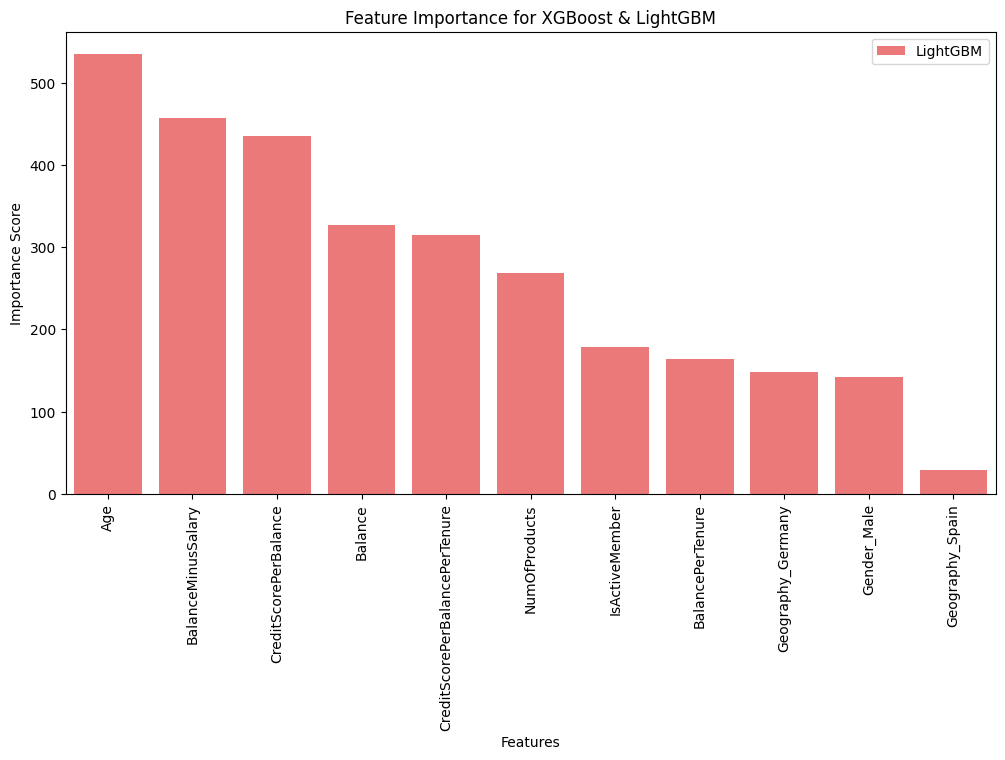

In [41]:

lgb_model = lgb.LGBMClassifier(verbose=-1)

lgb_model.fit(X, y)

# Get feature importance
lgb_importance = lgb_model.feature_importances_

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "LightGBM Importance": lgb_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.set_index("Feature")
feature_importance_df = feature_importance_df.sort_values(by="LightGBM Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
# sns.barplot(data=feature_importance_df, x=feature_importance_df.index, y="XGBoost Importance", color="blue", label="XGBoost")
sns.barplot(data=feature_importance_df, x=feature_importance_df.index, y="LightGBM Importance", color="red", alpha=0.6, label="LightGBM")

plt.xticks(rotation=90)
plt.title("Feature Importance for XGBoost & LightGBM")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.legend()
plt.show()

In [42]:
# import logging
# import lightgbm as lgb
# import optuna
# import numpy as np
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold

# # Configuration du logger
# logging.basicConfig(
#     filename="optuna_lightgbm.log",
#     level=logging.INFO,
#     format="%(asctime)s - %(levelname)s - %(message)s",
#     datefmt="%Y-%m-%d %H:%M:%S"
# )

# def log(message):
#     """ Fonction pour écrire les logs dans le fichier et afficher en console (optionnel). """
#     logging.info(message)
#     # print(message)  # Commente cette ligne si tu veux éviter d'afficher dans la console.

# # Optuna objective function
# def objective(trial):
#     params = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.015, log=True),  # ✅ Fix
#         "n_estimators": trial.suggest_int("n_estimators", 70, 1000),
#         "num_leaves": trial.suggest_int("num_leaves", 50, 250),
#         "subsample": trial.suggest_float("subsample", 0.5, 1),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
#         "random_state": 42,
#         "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 5.0),
#     }

#     skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
#     f1_scores = []

#     log(f"\n🔍 Evaluating Trial {trial.number + 1} with Parameters: {params}")

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = lgb.LGBMClassifier(**params)
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred)
#         f1_scores.append(f1)

#         log(f"📊 Fold {fold} - F1 Score: {f1:.4f}")

#     avg_f1 = np.mean(f1_scores)
#     log(f"✅ Trial {trial.number + 1} - Average F1 Score: {avg_f1:.4f}\n")

#     return avg_f1

# # Run Optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=3000)  

# # Print best parameters
# log("\n🎯 Best Hyperparameters for LightGBM:")
# log(str(study.best_params))
# log(f"💯 Best F1 Score: {study.best_value:.4f}")


In [43]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# Load test set
df_test = pd.read_csv('./data/test_data.csv')

# Encode categorical features (USE TRAINED ENCODER)
encoded_data_test = encoder.transform(df_test[["Gender", "Geography"]])
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoder.get_feature_names_out(["Gender", "Geography"]))

df_test = df_test.drop(columns=["Gender", "Geography"]).reset_index(drop=True)
df_test = pd.concat([df_test, encoded_df_test], axis=1)

# Feature Engineering
df_test["BalanceMinusSalary"] = df_test["Balance"] - df_test["EstimatedSalary"]
df_test["CreditScorePerBalance"] = df_test["CreditScore"] / (df_test["Balance"] +1)
df_test["CreditScorePerBalancePerTenure"] = df_test["CreditScorePerBalance"] / (df_test["Tenure"] +1)
df_test["BalancePerTenure"] = df_test["Balance"] / (df_test["Tenure"] +1)


# Save ID for submission
df_ID_copy = df_test["ID"].copy()

# Drop unnecessary columns
df_test.drop(columns=["CustomerId", "Surname", "ID", "Tenure", "CreditScore", "EstimatedSalary", "HasCrCard"], inplace=True)

# Scale numeric features (USE TRAINED SCALER)
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

# Ensure df_test has the same columns as X
missing_cols = set(X.columns) - set(df_test.columns)
if missing_cols:
    print(f"⚠️ Missing Columns in Test Set: {missing_cols}")
extra_cols = set(df_test.columns) - set(X.columns)
if extra_cols:
    print(f"⚠️ Extra Columns in Test Set: {extra_cols}")

# Load best model parameters
best_params = {
    "learning_rate": 0.013837962212682131,
    "n_estimators": 643,
    "num_leaves": 57,
    "subsample": 0.6579082122427545,
    "colsample_bytree": 0.8727954379817137,
    'scale_pos_weight': 1.9511815729607453,
    "objective": "binary",
    "metric": "binary_logloss",
    "random_state": 42,
}


# Train model on the full training set
model = lgb.LGBMClassifier(**best_params)
model.fit(X, y)

# Predict on test set
y_test_pred = model.predict(df_test)

# Create submission file
submission = pd.DataFrame({"ID": df_ID_copy, "Exited": y_test_pred})
submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' saved successfully!")

✅ Submission file 'submission.csv' saved successfully!
